 # <font color="#114b98">      <div align="center">  Développez une preuve de concept

Dans ce projet, on s'intéresse à mettre en oeuvre d'un approche récente pour un problème concret de data science et le comparer avec une apprcohe déja utilisée pour le même problème comme une méthode de baseline.
Nous avons choisi la segmentation d'images, en particulier des images sous-marines  

Dans ce Notebook nous allons tetser le modèle U-net comme méthode de baseline pour segmenter la dataset des images sous-marines.

Tous les Notebooks et un rapport du projet seront versionnés dans un repositoire GitHub disponible à l'adresse: https://github.com/Bounkass/Projet_7PoC

## <font color="#ea1c60">Sommaire</font>  
[1. Chargement et préparation des images](#section_1)

[2. Modèle U-net (méthode baseline)](#section_2)

[3. Inférence sur des données test ](#section_3) 

In [4]:
# import  python librairies
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import time

In [5]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda, Activation
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical, Sequence
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping ,ReduceLROnPlateau ,ModelCheckpoint


### <font id="section_1">1. Chargement et prépaaration des images

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
#path = "C:/Users/moumouni/Desktop/projet6/Images"
from zipfile import ZipFile
file_name = "/content/drive/MyDrive/P7_poc.zip"

with ZipFile(file_name, 'r') as zip:
    zip.extractall()
    print('Done!')

Done!


In [8]:
image_paths = '/content/train_val/images/'
mask_paths = '/content/train_val/masks/'

In [9]:
n_classes = 8

def build_dt(image_paths,mask_paths):
    name_img = []
    name_mask = []
    name_masks = []
    for dirname, _, filenames in os.walk(image_paths):
        for filename in filenames:
            name_img.append(image_paths+filename)
            name_mask.append(mask_paths+filename)
    dt = pd.DataFrame({'uri_image': name_img}, index = np.arange(0, len(name_img)))
    for file_name in name_mask:
      name_masks.append(file_name.split('.')[0]+".bmp")
    dt['uri_mask'] = name_masks
    return dt
dt = build_dt(image_paths,mask_paths)
print('Total Images: ', len(dt))

Total Images:  1525


In [7]:
dt.head()

,uri_image,uri_mask
0,/content/train_val/images/f_r_1913_.jpg,/content/train_val/masks/f_r_1913_.bmp
1,/content/train_val/images/f_r_1039_.jpg,/content/train_val/masks/f_r_1039_.bmp
2,/content/train_val/images/f_r_1161_.jpg,/content/train_val/masks/f_r_1161_.bmp
3,/content/train_val/images/w_r_166_.jpg,/content/train_val/masks/w_r_166_.bmp
4,/content/train_val/images/f_r_62_.jpg,/content/train_val/masks/f_r_62_.bmp


In [10]:
from sklearn.model_selection import train_test_split
# Split the data into a training set and a test set
X_train, X_val, y_train, y_val = train_test_split(dt.uri_image, dt.uri_mask, random_state=42)
X_test = build_dt('/content/TEST/images/','/content/TEST/masks/')['uri_image'].values
y_test = build_dt('/content/TEST/images/','/content/TEST/masks/')['uri_mask'].values
print('Train Size   : ', len(X_train))
print('Val Size     : ', len(X_val))
print('Test Size    : ', len(X_test))


Train Size   :  1143
Val Size     :  382
Test Size    :  110


Image Size (540, 960, 3)
Mask Size (540, 960, 3)
Image Size (480, 640, 3)
Mask Size (480, 640, 3)
Image Size (480, 640, 3)
Mask Size (480, 640, 3)
Image Size (480, 640, 3)
Mask Size (480, 640, 3)
Image Size (480, 640, 3)
Mask Size (480, 640, 3)
Image Size (480, 640, 3)
Mask Size (480, 640, 3)


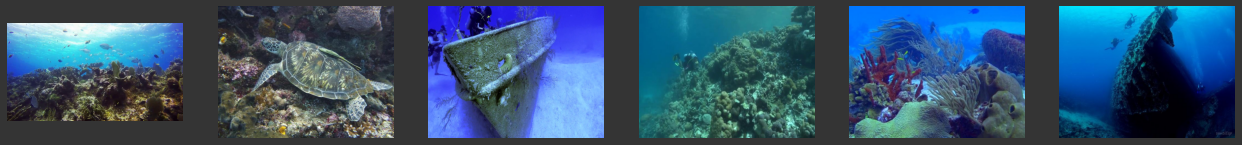

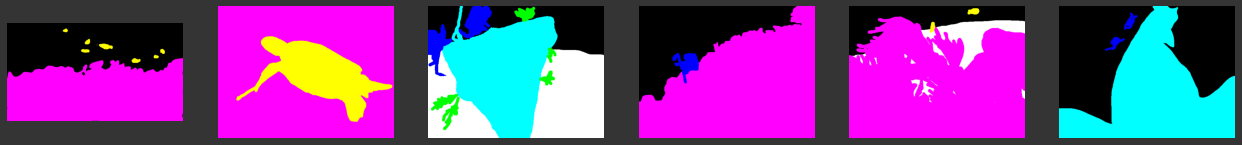

In [12]:
import matplotlib.image as mpimg
fig = plt.figure(figsize=(22,13))
fig.patch.set_facecolor('#343434')
fig1 = plt.figure(figsize=(22,13))
fig1.patch.set_facecolor('#343434')
ay = np.random.choice(range(0,500),6)
for i in range(0,len(ay)):
    ax = fig.add_subplot(1,6,i+1)
    ax1 = fig1.add_subplot(1,6,i+1)
    img = mpimg.imread(dt['uri_image'][ay[i]])
    img1 = mpimg.imread(dt['uri_mask'][ay[i]])
    print('Image Size', np.asarray(img).shape)
    print('Mask Size', np.asarray(img1).shape)
    ax.imshow(img)
    ax1.imshow(img1)
    ax.axis('off');
    ax1.axis('off');

In [13]:
classes = ['water', 'human divers', 'aquatic plants & sea-grass', 'wrecks & ruins', 'robots', 'reefs & invertebrates', 'fish & vertebrates', 'sea-floor & rocks']
palettes = [[0, 0, 0], [0, 0, 255], [0, 255, 0], [0, 255, 255], [255, 0, 0], [255, 0, 255], [255, 255, 0], [255, 255, 255]]
    

In [14]:
def labelize(label):
    m,n,b = label.shape
    ref = np.zeros((m,n))
    for idx,col in enumerate(palettes):
        ref[np.all(label == col,axis=-1)] = idx
    return ref

def IoU(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 0.01) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 0.01)

In [15]:
import tensorflow as tf
def augment(input_image, input_mask):
   if tf.random.uniform(()) > 0.5:
       # Random flipping of the image and mask
       input_image = tf.image.flip_left_right(input_image)
       input_mask = tf.image.flip_left_right(input_mask)
   return input_image, input_mask



Nous allons utiliser la classe DataGenerator  qui sera utilisée pour charger les images avec les masques correspondants  au fur et à mesure de l'entrainement du modèle.

In [16]:
class DataGenerator(Sequence):
    def __init__(self, list_IDs, list_labels, batch_size=32, img_dim = (256,256), n_channels = 3, n_classes=8, shuffle=True):
        'Initialization'
        self.dim = img_dim
        self.batch_size = batch_size
        self.labels = list_labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        list_lab_temp = [self.labels[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp, list_lab_temp)
        X, y= augment(X,y)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp, list_labels):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size, *self.dim), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            X[i,] = img_to_array(load_img(ID,target_size = ( *self.dim, self.n_channels), interpolation = 'bicubic'))/255

            # Store class
            yy = img_to_array(load_img(list_labels[i], target_size = ( *self.dim, self.n_channels), interpolation= 'nearest'))
            y[i,] = labelize(yy)
        return X, to_categorical(y, num_classes=self.n_classes)

### <font id="section_2">2. Modèle Unet

Nous créons une fonction build_unet_model avec la forme de l'image d'entrée est 256x256x3. La sortie comporte 8 canaux correspondant aux 8 classes pour lesquelles le modèle classera chaque pixel.

In [17]:
def conv_block(inputs, filters, pool=True):
    x = Conv2D(filters, 3, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(filters, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    if pool == True:
        p = MaxPooling2D((2,2))(x)
        p = Dropout(0.3)(p)
        return x, p
    else:
        return x
    
    
def build_unet(shape, num_classes):   
    inputs = Input(shape)
    
    filters_x = [32,64,96,128,128,96,64,32]
    filters_b = [256] 

    # Encoder
    x1, p1 = conv_block(inputs, filters_x[0], pool=True)
    x2, p2 = conv_block(p1, filters_x[1], pool=True)
    x3, p3 = conv_block(p2, filters_x[2], pool=True)
    x4, p4 = conv_block(p3, filters_x[3], pool=True)    
    
    # Bridge
    b1 = conv_block(p4, filters_b[0], pool=False)
    
    # Decoder
    u1 = UpSampling2D((2,2), interpolation='bilinear')(b1)
    c1 = Concatenate()([u1, x4])
    x5 = conv_block(c1, filters_x[4], pool=False)
    
    u2 = UpSampling2D((2,2), interpolation='bilinear')(x5)
    c2 = Concatenate()([u2, x3])
    x6 = conv_block(c2, filters_x[5], pool=False)
    
    u3 = UpSampling2D((2,2), interpolation='bilinear')(x6)
    c3 = Concatenate()([u3, x2])
    x7 = conv_block(c3, filters_x[6], pool=False)
    
    u4 = UpSampling2D((2,2), interpolation='bilinear')(x7)
    c4 = Concatenate()([u4, x1])
    x8 = conv_block(c4, filters_x[7], pool=False)
    
    # Output Layer
    output = Conv2D(num_classes, 1, padding='same', activation='softmax')(x8)

    return Model(inputs, output)

#### Compiler et entrainer le modèle U-Net

In [18]:
## Define the resolution of the images and the number of classes
H = 256
W = 256
num_classes = 8

model = build_unet((W, H, 3), num_classes)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [19]:
metrics=['accuracy', IoU]
loss = 'categorical_crossentropy'
model.compile(optimizer='adam', loss=loss, metrics=metrics)

In [20]:
#set training and validation data set 
batch_size =32
train_gen = DataGenerator( X_train.values,  y_train.values, batch_size=batch_size, 
                      img_dim = (256,256), n_channels = 3, n_classes=8, shuffle=True)
val_gen = DataGenerator( X_val.values,  y_val.values, batch_size=batch_size,
                      img_dim = (256,256), n_channels = 3, n_classes=8, shuffle=True)

In [21]:

#fit model
epochs = 50
time1 = time.time()
history = model.fit(train_gen,  validation_data=val_gen, epochs=epochs)
print("Total time of training in min:", round((time.time()-time1)/60,2))

Epoch 1/50
35/35 [==============================] - 71s 1s/step - loss: 1.4789 - accuracy: 0.5507 - IoU: 0.2108 - val_loss: 7.7274 - val_accuracy: 0.3173 - val_IoU: 0.1300
Epoch 2/50
35/35 [==============================] - 49s 1s/step - loss: 1.2656 - accuracy: 0.5980 - IoU: 0.2691 - val_loss: 2.4465 - val_accuracy: 0.1066 - val_IoU: 0.0808
Epoch 3/50
35/35 [==============================] - 50s 1s/step - loss: 1.1889 - accuracy: 0.6132 - IoU: 0.2924 - val_loss: 10.8815 - val_accuracy: 0.2939 - val_IoU: 0.1301
Epoch 4/50
35/35 [==============================] - 49s 1s/step - loss: 1.1589 - accuracy: 0.6204 - IoU: 0.3019 - val_loss: 9.0313 - val_accuracy: 0.3272 - val_IoU: 0.1625
Epoch 5/50
35/35 [==============================] - 48s 1s/step - loss: 1.1198 - accuracy: 0.6319 - IoU: 0.3135 - val_loss: 5.8144 - val_accuracy: 0.3361 - val_IoU: 0.1595
Epoch 6/50
35/35 [==============================] - 49s 1s/step - loss: 1.0876 - accuracy: 0.6361 - IoU: 0.3287 - val_loss: 3.7234 - val_ac

In [22]:
model.save('/content/drive/MyDrive/Saved_model/Unet_UWI.h5')

In [21]:
#load_model = model.load_weights("/content/drive/MyDrive/Saved_model/Unet_UWI.h5") 

### <font id="section_1">1. Chargement et prép-processing des images

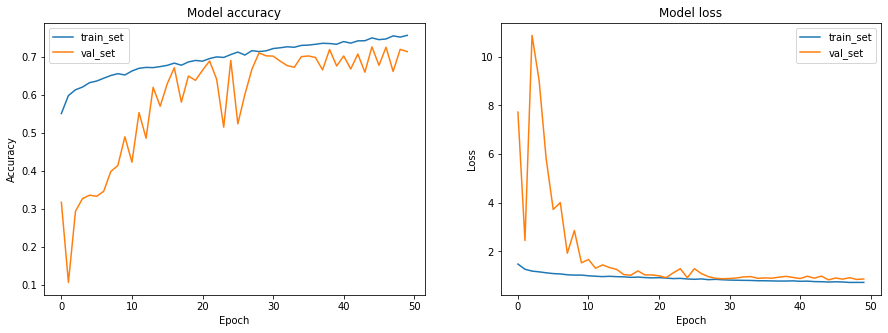

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
# summarize history for accuracy
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Model accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['train_set','val_set'])

# summarize history for loss
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Model loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend(['train_set','val_set'])

plt.show()

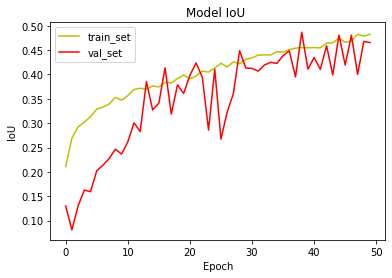

In [29]:
acc = history.history['IoU']
val_acc = history.history['val_IoU']

plt.plot(acc, 'y', label='train_set')
plt.plot(val_acc, 'r', label='val_set')
plt.title('Model IoU ')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.legend()
plt.show()


### <font id="section_3">3. Inférence sur des données test

Nous commençons d'abord de charger et préparer les images et leurs masques  test 

In [25]:
X_test = build_dt('/content/TEST/images/','/content/TEST/masks/')['uri_image'].values
y_test = build_dt('/content/TEST/images/','/content/TEST/masks/')['uri_mask'].values

In [26]:
test_img = []
test_mask = []
for k in range(0,len(X_test)):
   test_img.append(img_to_array(load_img(X_test[k],target_size = (H,W), interpolation = 'bicubic'))/255)
   test = img_to_array(load_img(y_test[k],target_size = (H,W), interpolation = 'bicubic'))/255
   test_mask.append(to_categorical(labelize(test),num_classes=8))

test_img = np.asarray(test_img)
test_mask = np.asarray(test_mask)

Nous allons utiliser le modèle entrainé pour faire des prédictions sur quelques exemples d'images de l'ensemble de données de test.


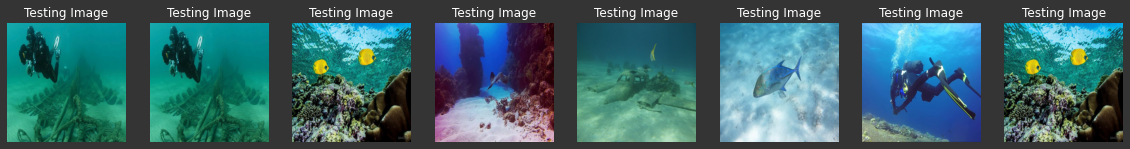

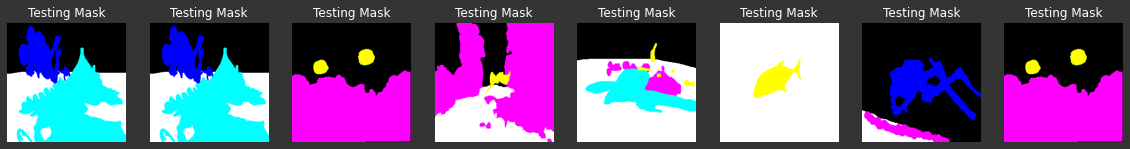

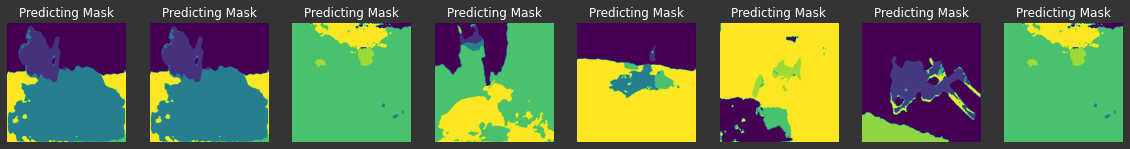

In [27]:
n_s=8
fig = plt.figure(figsize=(20,10))
fig.patch.set_facecolor('#343434')
fig1 = plt.figure(figsize=(20,10))
fig1.patch.set_facecolor('#343434')
fig2 = plt.figure(figsize=(20,10))
fig2.patch.set_facecolor('#343434')
idx_s = np.random.choice(range(0,len(y_test)),n_s)
for i in range(0,len(idx_s)):
    prediction = model.predict(np.expand_dims(test_img[idx_s[i]], 0))
    predicted_img = np.argmax(prediction, axis=3)
    ax = fig.add_subplot(1,n_s,i+1)
    ax1 = fig1.add_subplot(1,n_s,i+1)
    ax2 = fig2.add_subplot(1,n_s,i+1)
    ax.set_title('Testing Image',color='white')
    ax.imshow(test_img[idx_s[i]])
    ax1.set_title('Testing Mask',color='white')
    ax1.imshow(img_to_array(load_img(y_test[idx_s[i]],target_size = (H,W)))/255)
    ax2.set_title('Predicting Mask',color='white')
    ax2.imshow(predicted_img[0,:,:])
    ax.axis('off');
    ax1.axis('off');
    ax2.axis('off');

Calculons le score IoU sur l'ensemble des images test

In [30]:
y_pred=model.predict(test_img)
Jacc = IoU(test_mask,y_pred)
print('IoU = {}'.format(Jacc))

IoU = 0.244323268532753


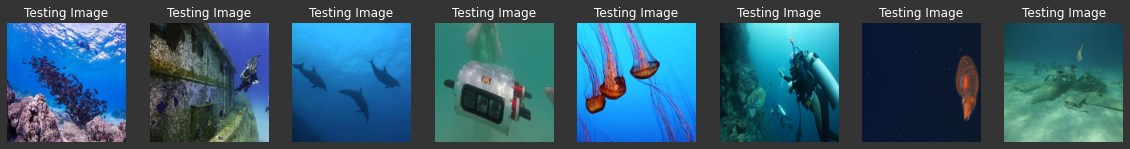

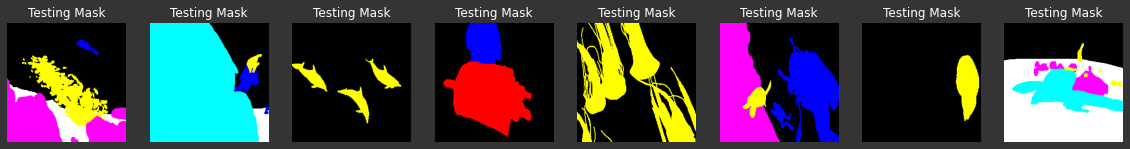

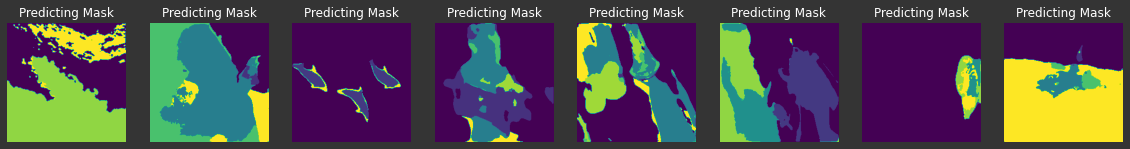

In [32]:
fig = plt.figure(figsize=(20,10))
fig.patch.set_facecolor('#343434')
fig1 = plt.figure(figsize=(20,10))
fig1.patch.set_facecolor('#343434')
fig2 = plt.figure(figsize=(20,10))
fig2.patch.set_facecolor('#343434')
#
idx_s=range(7,15)
for i in range(0,8):
    prediction = model.predict(np.expand_dims(test_img[idx_s[i]], 0))
    predicted_img = np.argmax(prediction, axis=3)
    ax = fig.add_subplot(1,n_s,i+1)
    ax1 = fig1.add_subplot(1,n_s,i+1)
    ax2 = fig2.add_subplot(1,n_s,i+1)
    ax.set_title('Testing Image',color='white')
    ax.imshow(test_img[idx_s[i]])
    ax1.set_title('Testing Mask',color='white')
    ax1.imshow(img_to_array(load_img(y_test[idx_s[i]],target_size = (H,W)))/255)
    ax2.set_title('Predicting Mask',color='white')
    ax2.imshow(predicted_img[0,:,:])
    ax.axis('off');
    ax1.axis('off');
    ax2.axis('off');